In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [3]:
seed = 42

In [4]:
train_image_paths_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/train_image_paths.csv', header=None, names=['path'], dtype=str)
train_labeled_studies_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/train_labeled_studies.csv', header=None, names=['path', 'label'], dtype=str)
valid_image_paths_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/valid_image_paths.csv', header=None, names=['path'], dtype=str)
valid_labeled_studies_df = pd.read_csv('/kaggle/input/mura-v11/MURA-v1.1/valid_labeled_studies.csv', header=None, names=['path', 'label'], dtype=str)

In [5]:
train_image_paths_df['parent_path'] = train_image_paths_df['path'].apply(lambda x: re.sub(r'image\d+.png', '', x))
train_labeled_studies_df[['part', 'patient_id', 'study_label']] = list(train_labeled_studies_df['path'].str.split('/').apply(lambda x: x[2:-1]))
train_merge = pd.merge(train_image_paths_df, train_labeled_studies_df, left_on='parent_path', right_on='path')
train_merge.drop(['parent_path', 'path_y', 'patient_id', 'study_label'], axis=1, inplace=True)
train_merge.rename({ 'path_x': 'path' }, axis=1, inplace=True)
label = train_merge.pop('label')
train_merge.insert(train_merge.shape[1], 'label', label)

In [6]:
valid_labeled_studies_df[['part', 'patient_id', 'study_label']] = list(valid_labeled_studies_df['path'].str.split('/').apply(lambda x: x[2:-1]))
valid_image_paths_df['parent_path'] = valid_image_paths_df['path'].apply(lambda x: re.sub(r'image\d+.png', '', x))
valid_merge = pd.merge(valid_image_paths_df, valid_labeled_studies_df, left_on='parent_path', right_on='path')
valid_merge.drop(['parent_path', 'path_y', 'patient_id', 'study_label'], axis=1, inplace=True)
valid_merge.rename({ 'path_x': 'path' }, axis=1, inplace=True)
label = valid_merge.pop('label')
valid_merge.insert(valid_merge.shape[1], 'label', label)

In [7]:
train_merge['path'] = '/kaggle/input/mura-v11/' + train_merge['path']
valid_merge['path'] = '/kaggle/input/mura-v11/' + valid_merge['path']

In [8]:
train_merge.head()

,path,part,label
0,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
1,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
2,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
3,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1
4,/kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...,XR_SHOULDER,1


In [9]:
valid_merge.head()

,path,part,label
0,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
1,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
2,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
3,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1
4,/kaggle/input/mura-v11/MURA-v1.1/valid/XR_WRIS...,XR_WRIST,1


In [10]:
train = train_merge
valid, test = train_test_split(valid_merge, test_size=0.5, random_state=seed)

In [11]:
image_generator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
)

In [12]:
im_size = 224

In [29]:
train_generator = image_generator.flow_from_dataframe(dataframe=train, x_col='path', y_col='label', class_mode='binary', batch_size=16, shuffle=True, target_size=(im_size, im_size), seed=seed)
valid_generator = image_generator.flow_from_dataframe(dataframe=valid, x_col='path', y_col='label', class_mode='binary', batch_size=16, shuffle=True, target_size=(im_size, im_size), seed=seed)
test_generator = image_generator.flow_from_dataframe(dataframe=test, x_col='path', y_col='label', class_mode='binary', batch_size=16, shuffle=False, target_size=(im_size, im_size), seed=seed)

Found 36808 validated image filenames belonging to 2 classes.
Found 1598 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.


In [14]:
input_shape=(im_size, im_size, 3)

# VGG19

In [52]:
vgg19 = VGG19(include_top=False, input_shape=input_shape, weights='imagenet', pooling='max')

In [53]:
vgg19.trainable = False

In [58]:
input_shape

(224, 224, 3)

In [59]:
inputs = tf.keras.layers.Input(shape=input_shape)
x = vgg19(inputs, training=False)
x = tf.keras.layers.Dropout(rate=0.2)(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

vgg19_model = tf.keras.Model(inputs, output)

In [60]:
vgg19_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,897 (76.39 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [61]:
vgg19_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[
        tf.keras.metrics.BinaryAccuracy()
    ]
)

In [57]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    mode="max",
    patience=5,
    restore_best_weights=True
)

In [62]:
history = vgg19_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   1/2301 ━━━━━━━━━━━━━━━━━━━━ 9:54:29 16s/step - binary_accuracy: 0.4375 - loss: 1.0158

I0000 00:00:1714221215.235407     139 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2301/2301 ━━━━━━━━━━━━━━━━━━━━ 804s 343ms/step - binary_accuracy: 0.5324 - loss: 0.7671 - val_binary_accuracy: 0.5576 - val_loss: 0.6914
Epoch 2/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 592s 256ms/step - binary_accuracy: 0.5812 - loss: 0.6934 - val_binary_accuracy: 0.5638 - val_loss: 0.6877
Epoch 3/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 584s 253ms/step - binary_accuracy: 0.5933 - loss: 0.6757 - val_binary_accuracy: 0.5463 - val_loss: 0.6999
Epoch 4/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 589s 255ms/step - binary_accuracy: 0.6078 - loss: 0.6636 - val_binary_accuracy: 0.5713 - val_loss: 0.6792
Epoch 5/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 584s 253ms/step - binary_accuracy: 0.6117 - loss: 0.6555 - val_binary_accuracy: 0.5663 - val_loss: 0.6743
Epoch 6/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 582s 252ms/step - binary_accuracy: 0.6135 - loss: 0.6488 - val_binary_accuracy: 0.5751 - val_loss: 0.6680
Epoch 7/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 580s 251ms/step - binary_accuracy: 0.6212 - loss: 0.6450 - val_binary_accuracy: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2301/2301 ━━━━━━━━━━━━━━━━━━━━ 570s 247ms/step - binary_accuracy: 0.6312 - loss: 0.6362 - val_binary_accuracy: 0.5982 - val_loss: 0.6560
Epoch 12/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 579s 251ms/step - binary_accuracy: 0.6314 - loss: 0.6354 - val_binary_accuracy: 0.5889 - val_loss: 0.6573
Epoch 13/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 586s 254ms/step - binary_accuracy: 0.6344 - loss: 0.6326 - val_binary_accuracy: 0.5763 - val_loss: 0.6622
Epoch 14/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 583s 253ms/step - binary_accuracy: 0.6311 - loss: 0.6358 - val_binary_accuracy: 0.5995 - val_loss: 0.6600
Epoch 15/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 584s 253ms/step - binary_accuracy: 0.6262 - loss: 0.6364 - val_binary_accuracy: 0.5939 - val_loss: 0.6587


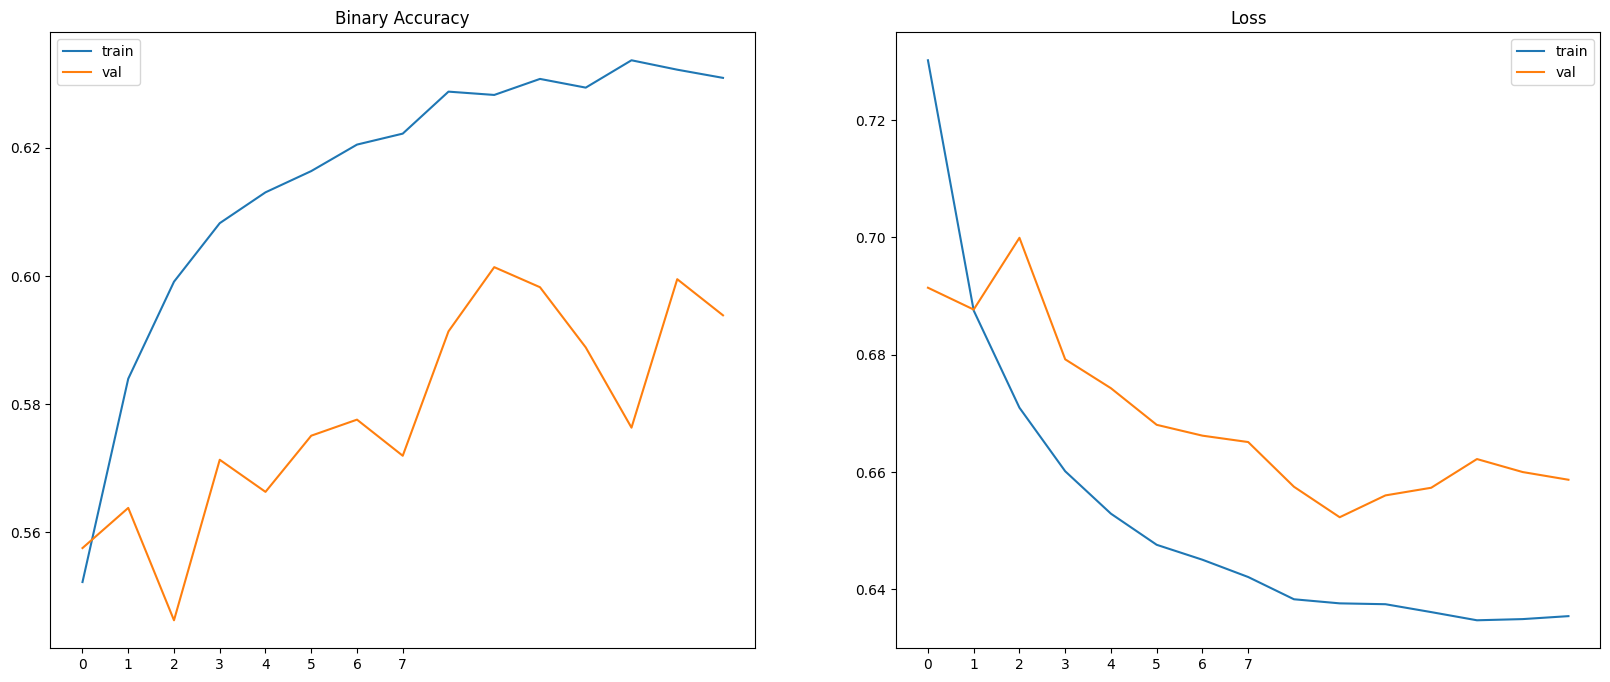

In [63]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='val')
plt.xticks(range(0, 8, 1))
plt.title('Binary Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xticks(range(0, 8, 1))
plt.title('Loss')
plt.legend()
plt.show()

In [64]:
evaluate_results = vgg19_model.evaluate(test_generator)
evaluate_results

100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 407ms/step - binary_accuracy: 0.5836 - loss: 0.6499


[0.6502541899681091, 0.6028767824172974]

In [65]:
vgg19_model.save('vgg19_model.keras')

In [66]:
print(classification_report(test_generator.labels, (vgg19_model.predict(test_generator) >= 0.5).astype(int)))

100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step
              precision    recall  f1-score   support

           0       0.58      0.85      0.69       830
           1       0.68      0.33      0.44       769

    accuracy                           0.60      1599
   macro avg       0.63      0.59      0.57      1599
weighted avg       0.63      0.60      0.57      1599



In [70]:
vgg19.trainable = True

In [71]:
vgg19_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=[
        tf.keras.metrics.BinaryAccuracy()
    ]
)

In [72]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_binary_accuracy",
    patience=4,
    mode="max",
    factor=0.2,
    min_lr=1e-10,
)

In [73]:
history = vgg19_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Epoch 1/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 647s 272ms/step - binary_accuracy: 0.6724 - loss: 0.6022 - val_binary_accuracy: 0.7278 - val_loss: 0.5466 - learning_rate: 1.0000e-05
Epoch 2/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 608s 263ms/step - binary_accuracy: 0.7558 - loss: 0.5122 - val_binary_accuracy: 0.7303 - val_loss: 0.5375 - learning_rate: 1.0000e-05
Epoch 3/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 611s 265ms/step - binary_accuracy: 0.7739 - loss: 0.4837 - val_binary_accuracy: 0.7466 - val_loss: 0.5147 - learning_rate: 1.0000e-05
Epoch 4/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 605s 262ms/step - binary_accuracy: 0.7868 - loss: 0.4583 - val_binary_accuracy: 0.7716 - val_loss: 0.4900 - learning_rate: 1.0000e-05
Epoch 5/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 608s 263ms/step - binary_accuracy: 0.8029 - loss: 0.4343 - val_binary_accuracy: 0.7666 - val_loss: 0.5156 - learning_rate: 1.0000e-05
Epoch 6/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 610s 264ms/step - binary_accuracy: 0.8138 - loss: 0.4242 - val_binary_accuracy

In [75]:
history1 = vgg19_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Epoch 1/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 588s 255ms/step - binary_accuracy: 0.8496 - loss: 0.3457 - val_binary_accuracy: 0.7647 - val_loss: 0.5232 - learning_rate: 1.0000e-05
Epoch 2/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 580s 251ms/step - binary_accuracy: 0.8545 - loss: 0.3374 - val_binary_accuracy: 0.7885 - val_loss: 0.5041 - learning_rate: 1.0000e-05
Epoch 3/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 577s 250ms/step - binary_accuracy: 0.8654 - loss: 0.3110 - val_binary_accuracy: 0.7816 - val_loss: 0.5276 - learning_rate: 1.0000e-05
Epoch 4/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 576s 250ms/step - binary_accuracy: 0.8692 - loss: 0.3054 - val_binary_accuracy: 0.7904 - val_loss: 0.5294 - learning_rate: 1.0000e-05
Epoch 5/10
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 631s 253ms/step - binary_accuracy: 0.8817 - loss: 0.2844 - val_binary_accuracy: 0.7804 - val_loss: 0.5831 - learning_rate: 1.0000e-05


In [76]:
acc = [*history.history['binary_accuracy'], *history1.history['binary_accuracy']]
val_acc = [*history.history['val_binary_accuracy'], *history1.history['val_binary_accuracy']]
loss = [*history.history['loss'], *history1.history['loss']]
val_loss = [*history.history['val_loss'], *history1.history['val_loss']]

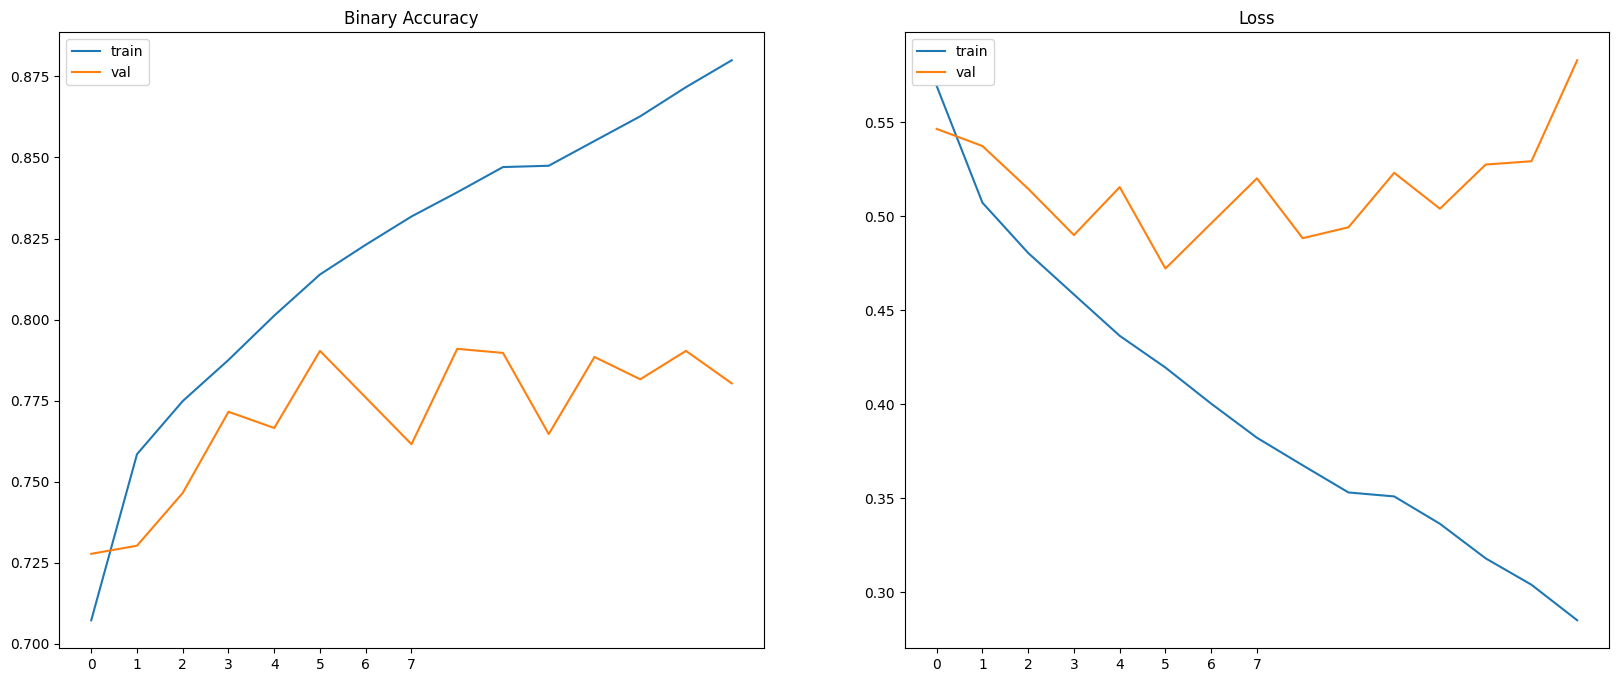

In [77]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(acc, label='train')
plt.plot(val_acc, label='val')
plt.xticks(range(0, 8, 1))
plt.title('Binary Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='train')
plt.plot(val_loss, label='val')
plt.xticks(range(0, 8, 1))
plt.title('Loss')
plt.legend()
plt.show()

In [80]:
vgg19_model.save('vgg19_model.keras')

In [82]:
evaluate_results = vgg19_model.evaluate(test_generator)
evaluate_results

100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 252ms/step - binary_accuracy: 0.7685 - loss: 0.5483


[0.5397403240203857, 0.774233877658844]

In [83]:
print(classification_report(test_generator.labels, (vgg19_model.predict(test_generator) >= 0.5).astype(int)))

100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       830
           1       0.77      0.75      0.76       769

    accuracy                           0.77      1599
   macro avg       0.77      0.77      0.77      1599
weighted avg       0.77      0.77      0.77      1599

